# Sheet 03

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

## (2) Visualize Regularization Contours

x.shape: (2, 100), "y.shape:" (1, 100)


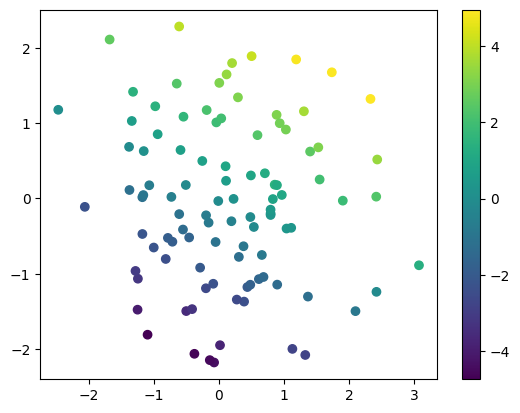

In [3]:
# load the data
data = np.load('data/linreg.npz')
x = data['X']
y = data['Y']
print(f'x.shape: {x.shape}, "y.shape:" {y.shape}')
plt.scatter(*x, c=y);
plt.colorbar()
plt.show()

In [4]:
# create a grid of points in the parameter space
b1, b2 = np.linspace(-1, 3, 101), np.linspace(-1, 3, 101)
bs = np.stack(np.meshgrid(b1, b2, indexing='ij'), axis=-1)
bs.shape

(101, 101, 2)

### (a)

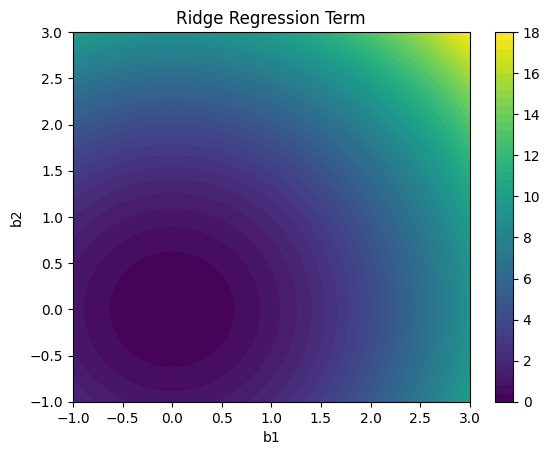

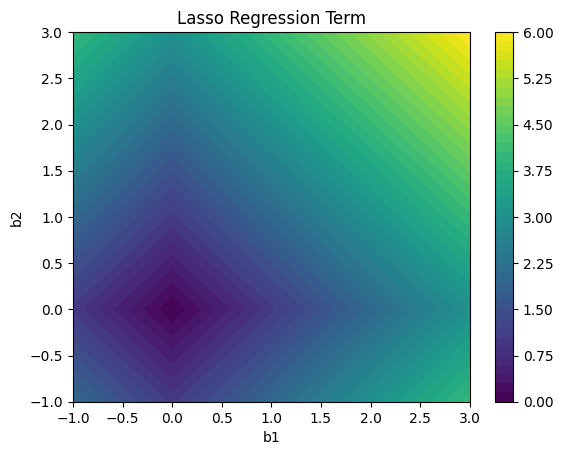

In [5]:
# Define ridge regression term
def ridge_term(b, alpha=1.0):
    return alpha * np.sum(b**2, axis=-1)

# Plot ridge regression contour
plt.contourf(b1, b2, ridge_term(bs), levels=50)
plt.colorbar()
plt.xlabel('b1')
plt.ylabel('b2')
plt.title('Ridge Regression Term')
plt.show()

# define lasso regression term
def lasso_term(b, alpha=1.0):
    return alpha * np.sum(np.abs(b), axis=-1)

# Plot lasso regression contour
plt.contourf(b1, b2, lasso_term(bs), levels=50)
plt.colorbar()
plt.xlabel('b1')
plt.ylabel('b2')
plt.title('Lasso Regression Term')
plt.show()

In [6]:
x.shape

(2, 100)

### (b)

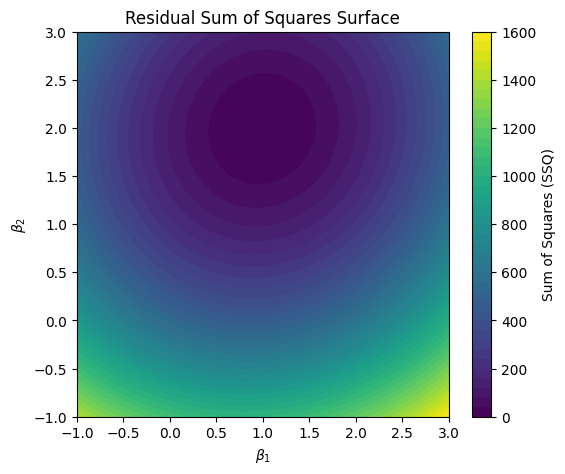

In [7]:
# Initialise SSQ array
SSQ = np.zeros((len(b1), len(b2)))

# Compute SSQ for each (β₁, β₂) pair
for i in range(len(b1)):
    for j in range(len(b2)):
        beta = bs[i, j, :]  # (β₁, β₂)
        X_T = x.T  # before (2,100), now (100, 2)
        y_pred = X_T @ beta  # works! (100,2) @ (2,) -> (100,)
        SSQ[i, j] = np.sum((y - y_pred)**2)

# Plot contour
plt.figure(figsize=(6, 5))
plt.contourf(b1, b2, SSQ.T, levels=50, cmap="viridis")
plt.colorbar(label="Sum of Squares (SSQ)")
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("Residual Sum of Squares Surface")
plt.show()

### (c)

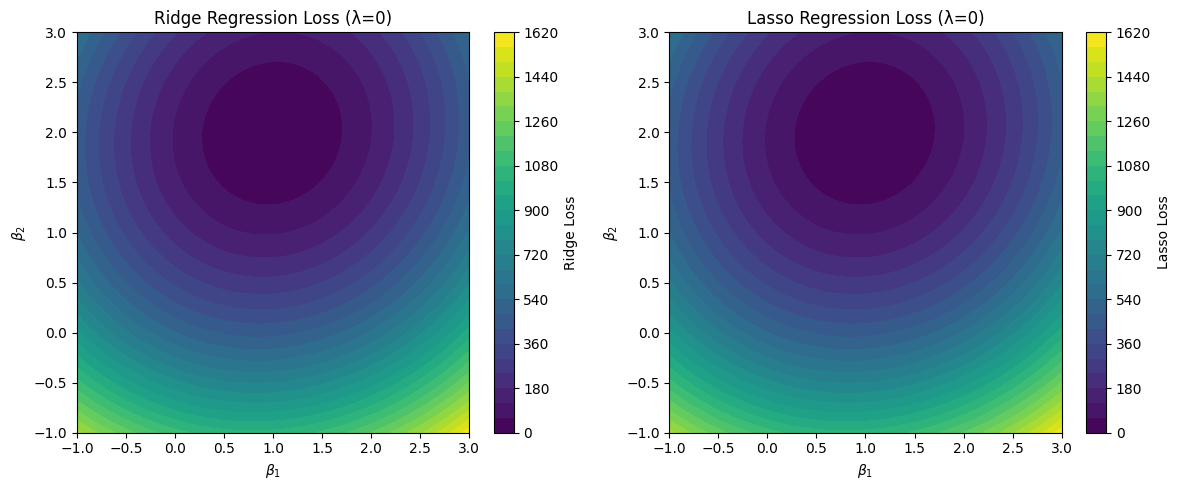

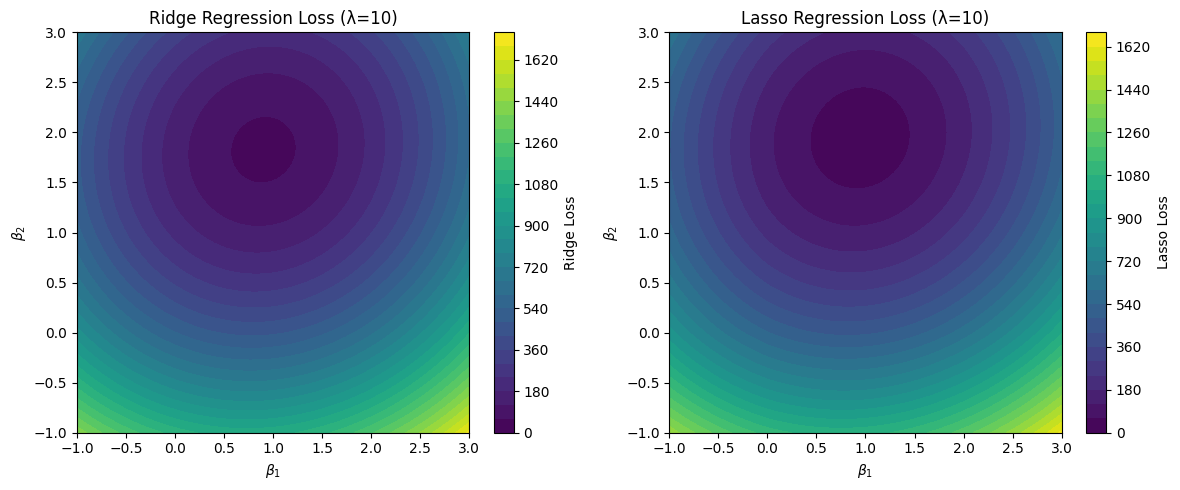

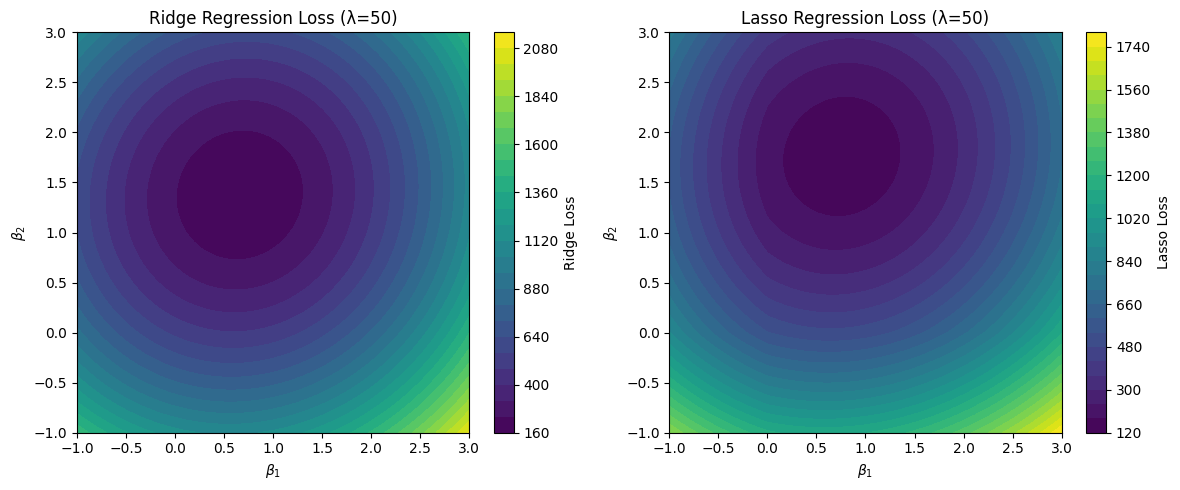

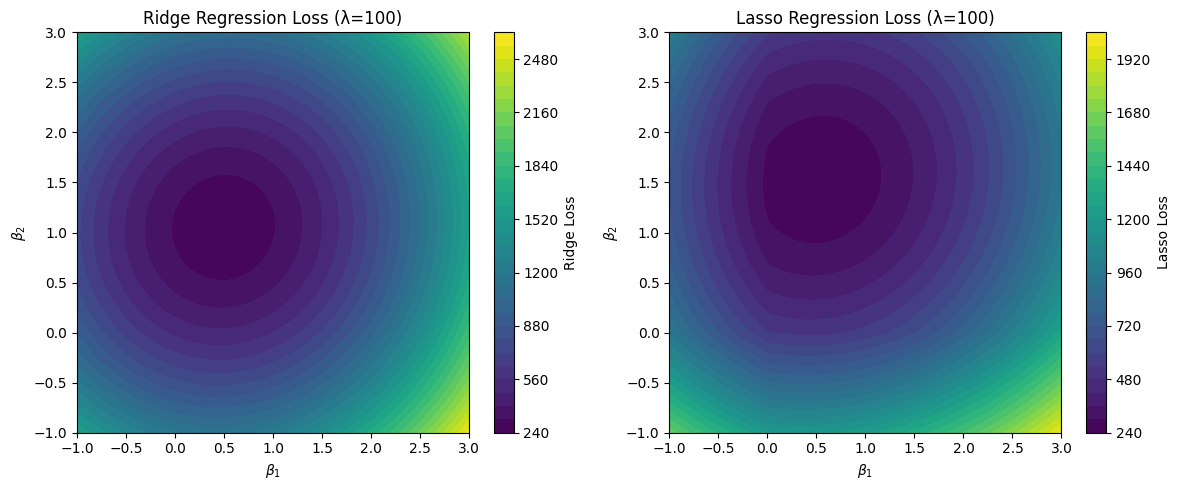

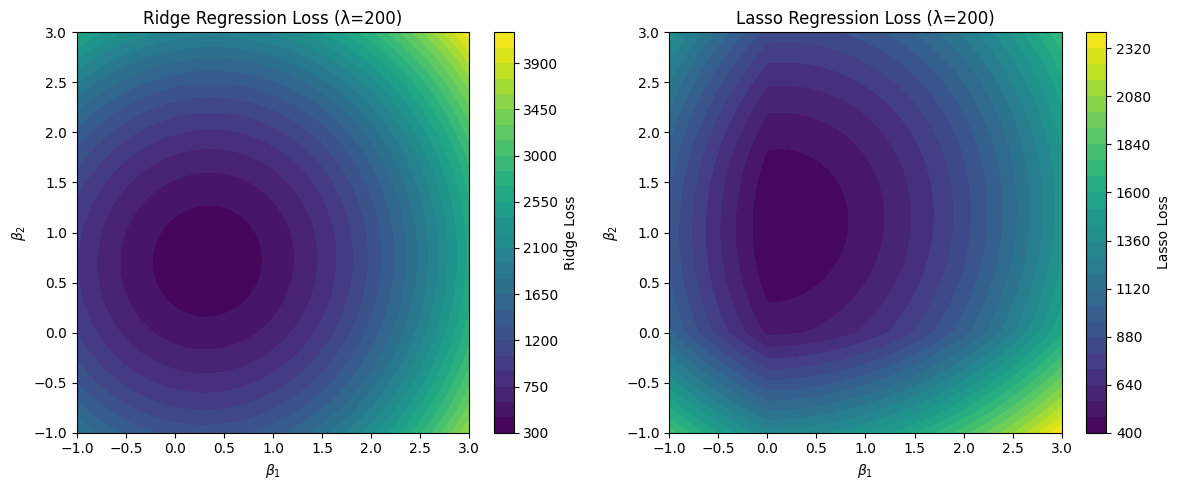

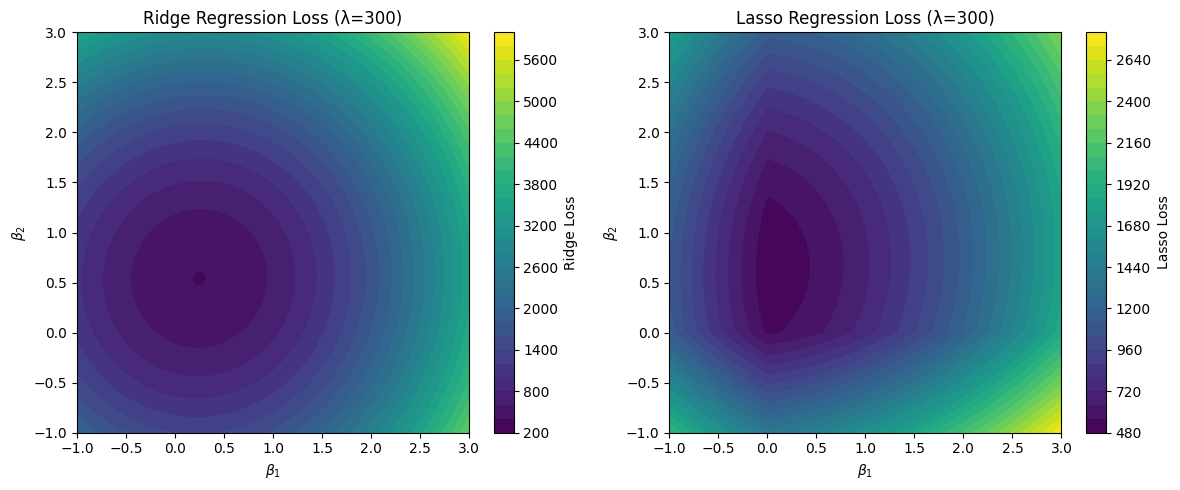

In [8]:
# TODO: for each lambda, plot both ridge regression and lasso loss functions
lambdas = [0, 10, 50, 100, 200, 300]

for lam in lambdas:
    ridge_loss = SSQ + ridge_term(bs, alpha=lam)
    lasso_loss = SSQ + lasso_term(bs, alpha=lam)

    # Plot ridge regression loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.contourf(b1, b2, ridge_loss.T, levels=30, cmap="viridis")
    plt.colorbar(label="Ridge Loss")
    plt.xlabel(r"$\beta_1$")
    plt.ylabel(r"$\beta_2$")
    plt.title(f"Ridge Regression Loss (λ={lam})")

    # Plot lasso regression loss
    plt.subplot(1, 2, 2)
    plt.contourf(b1, b2, lasso_loss.T, levels=30, cmap="viridis")
    plt.colorbar(label="Lasso Loss")
    plt.xlabel(r"$\beta_1$")
    plt.ylabel(r"$\beta_2$")
    plt.title(f"Lasso Regression Loss (λ={lam})")

    plt.tight_layout()
    plt.show()

## (3) CT Reconstruction
First, set up the design matrix. (Run this once to save it to the disk.)

In [9]:
# create design matrix
# don't change any of this, just run it once to create and save the design matrix
import os

n_parallel_rays = 70 
n_ray_angles = 30
res = (99, 117)
print("Number of pixels in the 2d image:", np.prod(res))
print("Total number of rays:", n_parallel_rays * n_ray_angles)

def rot_mat(angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.stack([np.stack([c, s], axis=-1), np.stack([-s, c], axis=-1)], axis=-1)

kernel = lambda x: np.exp(-x**2/sigma**2/2)

if not os.path.exists('data/design_matrix.npy'):
    xs = np.arange(0, res[1]+1) - res[1]/2 # np.linspace(-1, 1, res[1] + 1)
    ys = np.arange(0, res[0]+1) - res[0]/2 # np.linspace(-1, 1, res[0] + 1)

    # rays are defined by origin and direction
    ray_offset_range = [-res[1]/1.5, res[1]/1.5]
    n_rays = n_parallel_rays * n_ray_angles

    ray_angles = np.linspace(0, np.pi, n_ray_angles, endpoint=False) + np.pi/n_ray_angles

    # offsets for ray_angle = 0, i.e. parallel to x-axis
    ray_0_offsets = np.stack([np.zeros(n_parallel_rays), np.linspace(*ray_offset_range, n_parallel_rays)], axis=-1)
    ray_0_directions = np.stack([np.ones(n_parallel_rays), np.zeros(n_parallel_rays)], axis=-1)

    

    ray_rot_mats = rot_mat(ray_angles)

    ray_offsets = np.einsum('oi,aij->aoj', ray_0_offsets, ray_rot_mats).reshape(-1, 2)
    ray_directions = np.einsum('oi,aij->aoj', ray_0_directions, ray_rot_mats).reshape(-1, 2)

    sigma = 1
    xsc = (xs[1:] + xs[:-1]) / 2
    ysc = (ys[1:] + ys[:-1]) / 2
    b = np.stack(np.meshgrid(xsc, ysc), axis=-1).reshape(-1, 2)
    a = ray_offsets
    v = ray_directions
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    p = ((b[None] - a[:, None]) * v[:, None]).sum(-1, keepdims=True) * v[:, None] + a[:, None]
    d = np.linalg.norm(b - p, axis=-1)
    d = kernel(d)
    design_matrix = d.T

    np.save('data/design_matrix.npy', design_matrix)
    print(f'created and saved design matrix of shape {design_matrix.shape} at data/design_matrix.npy')

Number of pixels in the 2d image: 11583
Total number of rays: 2100


sino shape: (1, 2100)


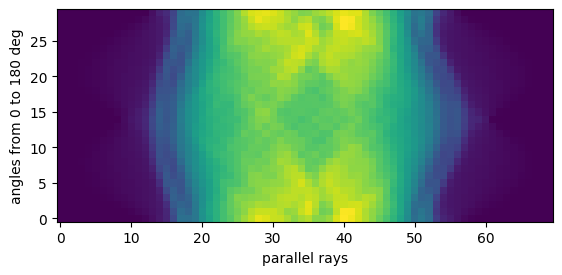

In [10]:
sino = np.load('data/sino.npy')

print(f'sino shape: {sino.shape}')

# visualize sinogram as image
n_parallel_rays = 70
n_angles = 30
plt.imshow(sino.reshape(n_angles, n_parallel_rays), origin='lower')
# plt.colorbar()
plt.xlabel('parallel rays')
plt.ylabel('angles from 0 to 180 deg')
plt.show();

### (a)

(11583,)
(11583,)
(11583,)
(11583,)


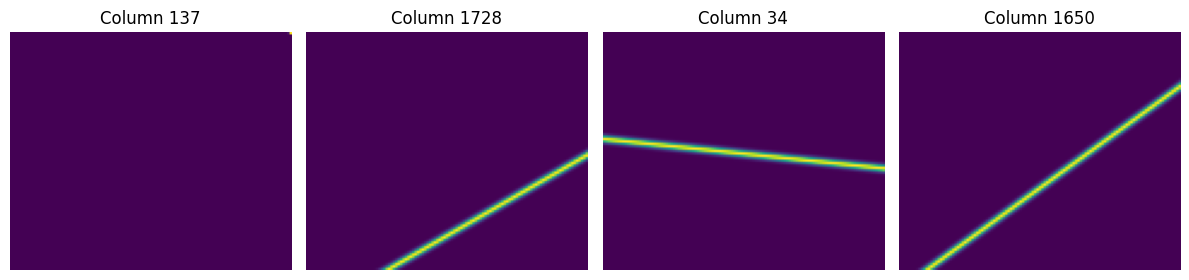

In [11]:
design_matrix = np.load('data/design_matrix.npy')

# TODO: visualize four random columns as images, using an image shape of (99, 117)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    # select random column index
    col_idx = np.random.randint(design_matrix.shape[1])
    print(design_matrix[:, col_idx].shape)

    # reshape column to image shape
    img = design_matrix[:, col_idx].reshape(99, 117)

    # plot the image
    axs[i].imshow(img, origin='lower')
    axs[i].set_title(f'Column {col_idx}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

The columns give the different detector readings, meaning one specific column  corresponds to a single pixel of the image and how it contributes to all detector readings.

### (b)

(2100,)
(2100,)
(2100,)
(2100,)


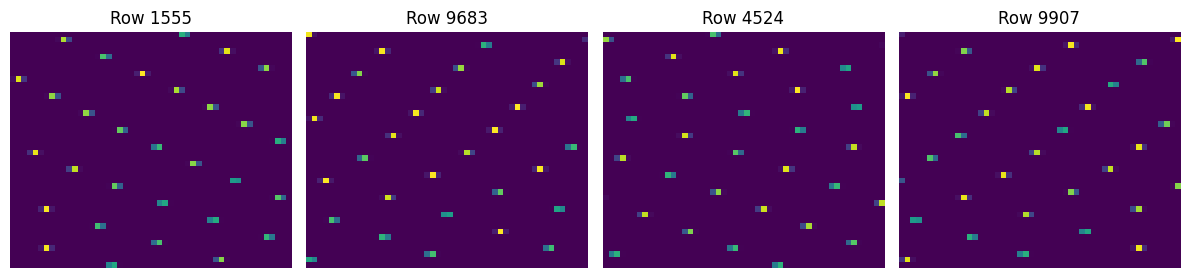

In [12]:
# TODO: visualize four random rows as images
fig , axs = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    # Select random row index
    row_idx = np.random.randint(design_matrix.shape[0])
    print(design_matrix[row_idx, :].shape)

    # Reshape row to image shape (2100 = 42*50)
    img = design_matrix[row_idx, :].reshape(42, 50)  

    # Plot the image
    axs[i].imshow(img, origin='lower')
    axs[i].set_title(f'Row {row_idx}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

The rows give the different 2D slices. One individual row corresponds to a single detector reading.

### (c)

In [13]:
# check shapes and solve (adapt names A and sino to your variables)
A = design_matrix.T            # expected shape (m, n)
b = sino.T                     # expected shape (m,)  or (m, 1) or (m, k)

print("A.shape (m,n) =", A.shape)
print("b.shape (m,) or (m,k) =", b.shape)

# ensure b is a 1D or 2D array with matching first dimension
b = b.ravel() if b.ndim == 2 and b.shape[1] == 1 else b
assert A.shape[0] == b.shape[0], "number of rows in A must equal length of b (m)"

A.shape (m,n) = (2100, 11583)
b.shape (m,) or (m,k) = (2100, 1)


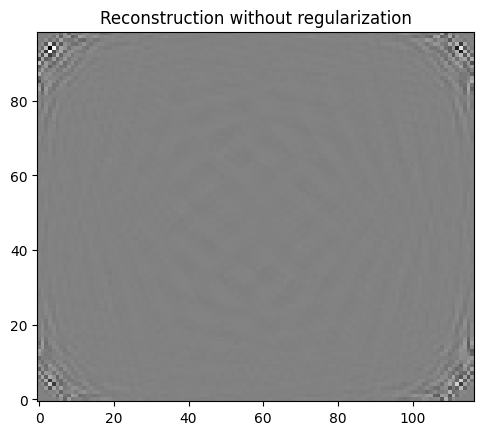

In [14]:
# TODO: solve the reconstruction with linear regression and visualize the result
I_hat = np.linalg.lstsq(A, b, rcond=None)[0]
image_recon = I_hat.reshape(99, 117)
plt.imshow(image_recon, cmap='gray', origin='lower')
plt.title('Reconstruction without regularization')
plt.show()


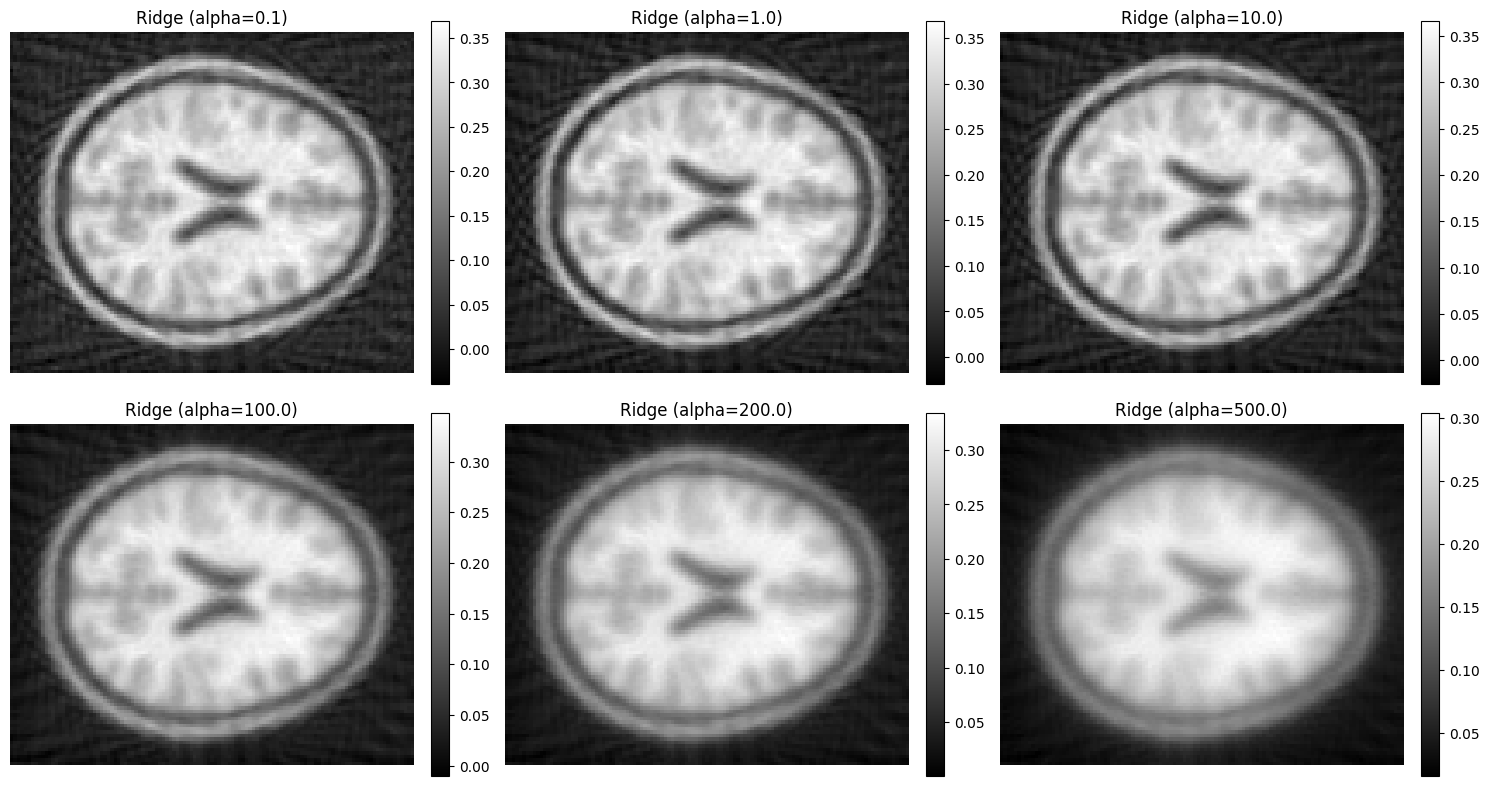

In [15]:
# TODO: Same with ridge regression for different alphas
from sklearn.linear_model import Ridge

# define range of alphas to test
alphas = [0.1, 1.0, 10.0, 100.0, 200.0, 500.0]
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# loop over alphas and plot reconstructions
for ax, alpha in zip(axs.flat, alphas):
    # fit ridge regression model
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(A, b)
    I_ridge = ridge.coef_.ravel()

    # reshape and plot the reconstructed image
    im = ax.imshow(I_ridge.reshape(99, 117), cmap='gray', origin='lower')
    ax.set_title(f'Ridge (alpha={alpha})')
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

With ridge regularisation a brain cut is visible. For larger regularisation strengths it becomes more blurry.